In [1]:

import numpy as np
from obspy.core.trace import Trace
import cwt
from matplotlib import pyplot as plt
import betterCWT

Add notes on data 

### Load data from paper implementation. 

windows have shape (286, 15000): 286 channels and 5 minute window length. Windows overlap by 2.5 minutes so 7500 samples. 

In [2]:
#load data with shape (nchannels, nSamples)
window_one = np.load("./TestData/stanford_numpy/2016-09-02_23:59:54training_prep.npy")
window_two =np.load("./TestData/stanford_numpy/2016-09-03_00:01:54training_prep.npy")

print("data shape: ", window_one.shape)

data = np.concatenate([window_one, window_two], axis=1, dtype=np.float64)
print(data.shape)

data shape:  (286, 15000)
(286, 30000)


### Parameter for CWT that will be used later 

window_size: the length of the cwt window in seconds

n_channels: the number of channels in the data 

n_samples: the total samples in the data

n_features: number of features per sample after performing cwt 30 will be on the time axis 30 will be on the spacial axis

samples_per_second: samples taken per second at each channel

samples_within_average: the amount of cwt features that will be average per set in the final output

n_sub_samples: n_samples/samples_within_average amount of samples that will be in the final output

delta: 1/samples_per_second or the sample period 

freq_min: min frequency allowed through bandpass filter 

freq_max: max frequency allowed through bandpass filter

freq_min_space: min frequency used for the spatial scales of cwt 

freq_max_space: max frequency used for spatial scales of cwt

time_scales: scales for time cwt 

spatial_scales: scales for spatial cwt



In [3]:
window_size = 300
n_channels = data.shape[0]
n_samples = data.shape[1]
n_features = 60
samples_per_second = 50
samples_within_average = 25
n_sub_samples = int(n_samples / samples_within_average)
delta = 1.0 / float(samples_per_second)
freq_min = 0.2
freq_max = 24.0
freq_min_space= 0.04
freq_max_space= 2
w0 =8

time_log = np.logspace(np.log10(freq_min), np.log10(freq_max), 30)
space_log = np.logspace(np.log10(freq_min_space), np.log10(freq_max_space), 30)

time_scales = cwt.scales_from_fourier(time_log, wf="morlet", w0=8)
spatial_scales = cwt.scales_from_fourier(space_log, wf="morlet", w0=8)
print(time_scales)

[ 0.25662204  0.30268428  0.35701443  0.42109654  0.49668103  0.58583253
  0.69098622  0.81501442  0.96130499  1.13385391  1.3373744   1.5774257
  1.86056487  2.19452595  2.5884312   3.05304026  3.60104407  4.24741153
  5.00979836  5.90902941  6.96966744  8.22068413  9.69625138 11.43667478
 13.48949453 15.91078406 18.76668163 22.135197   26.10834221 30.79464498]


### formula to calculate sacles from frequency where $ \lambda$ = frequency
$$ scale = \frac{\lambda(\omega_0 + \sqrt{2 + \omega_0})}{4\pi}  $$

### formula for angular frequencies
$$ w_k = \begin{cases} 
   \frac{2 \pi k}{dt} & \text{ k $\le \frac{N}{2} $ }\\
   -\frac{2 \pi k}{dt} & \text{ k >$\ \frac{N}{2} $ }\\
    \end{cases}$$

### formula for morlet wavelet


$$ \psi_0(N) = \pi^{ -\frac{1}{4}} e^{iw_0N} e^{-n^2/2}
$$

### formula for morlet wavelet at a scale 


$$ \psi_0(sw) = \pi^{ -\frac{1}{4}} H(w) e^{-(sw - w_0)^2/2}
$$

### Normalization term for wavelet

$$ \sqrt{ \frac{2\pi s}{dt}}$$

In [18]:
def cwt_vec(signal, log_space, omega_0, dt):
    #calculate the scales for cwt
    scales = (log_space*(omega_0 + np.sqrt(2 + omega_0**2)))/ (4 * np.pi)
    #calculate angular frequencies
    angular_freq = ((2*np.pi * np.arange(signal.shape[0])) / (signal.shape[0]* dt))
    # reflect the second half of the array
    angular_freq[(signal.shape[0] //2):] *= -1
    #H(w)
    heavy_step = angular_freq > 0
 
    #compute wavelet point 
    wavelet = np.zeros((signal.shape[0], scales.shape[0]), dtype=np.complex128)
    wavelet[heavy_step,:]= np.sqrt((scales *2 * np.pi)/ dt) * (np.pi ** -.25) * np.exp(-((np.outer(angular_freq[heavy_step], scales) - omega_0)**2) / 2)

    #zero mean 
    signal -= np.mean(signal)
    
    fft_signal = np.fft.fft(signal)
    result = np.array((wavelet.shape[1], fft_signal.shape[0]), dtype=np.complex128)
    result = np.fft.ifft(wavelet.T * fft_signal, axis=1)
    
    return result
    

## This transforms one window of data 

In [29]:
def transform_window(data):
    """transform a window of data from stanford array 

    Args:
        data (np.array(286, 15000)): window size should be 5 min/ 15000 samples 

    Returns:
        cwt transformed data : np.array(286, 300,60) only samples from 250:7750 are used so result is 2.5 minutes long
    """
    n_samples=data.shape[1]
    
    #take time derivative 
    data_derivative = data[:, 1:] - data[:, :-1]

    # perform bandpass filter to remove high and low frequencies
    # TODO can this be done faster 
    for channel in range(n_channels):
        trace = Trace(data=data_derivative[channel, :], header={'delta':1.0/float(samples_per_second),'sampling_rate':samples_per_second})
        trace = trace.filter("bandpass", freqmin= freq_min, freqmax= freq_max, corners=4, zerophase=True)
        data_derivative[channel, :] = trace.data
        

    #remove lazer drift/ remove median
    data_derivative = data_derivative - np.median(data_derivative, axis=0)
    print("data before Transform ", data_derivative.shape)


    transformed_data = np.empty((n_channels, n_samples-1, 60), dtype=np.float64)
    #new_transformed_data = np.empty((n_channels, n_samples-1, 60), dtype=np.float64)
    print(data_derivative.shape)
    
    #TODO how can I get rid of these loops 
    for index, sample in enumerate(data_derivative):
        transformed_data[index, : , :30] = np.abs(cwt_vec(sample, time_log, w0, delta).T) 

    for index, channel in enumerate(data_derivative.T):
        transformed_data[:, index, 30:] = np.abs(cwt_vec(channel, space_log, w0, delta).T)
        
    print(transformed_data.shape)

    #average samples over 0.5 second intervals 

    #start is at 250 since stanford windows start at 54.9 so add 5 seconds to start at the top of 
    reshaped_data = np.reshape(transformed_data[:, 250: 7750, :], (n_channels, 300, samples_within_average, 60))

    averaged_data = np.mean(reshaped_data, axis=2)
    return averaged_data




### Perform cwt on two windows of data 

In [30]:

result = np.empty((n_channels, 600, 60), dtype=np.float64)
#window one is len of 15000 samples or 5 minutes 
result[:,:300,:] = transform_window(window_one)
#window two is the same size but shifted 2.5 minutes from window 1
result[:,300:,:] = transform_window(window_two)


data before Transform  (286, 14999)
(286, 14999)
time transform done
(286, 14999, 60)
data before Transform  (286, 14999)
(286, 14999)
time transform done
(286, 14999, 60)


Normalize data by removing mean and scale variance to 1

In [31]:

#Do normilization 
trainingData = result
print(f'shape of data before normalization reshape {trainingData.shape}')
trainingData = np.reshape(trainingData, (n_channels * trainingData.shape[1], -1))
print(f'shape after rshape {trainingData.shape}')

#does the same thing as the papers sklearn 
trainingData = (trainingData - np.mean(trainingData, axis=0, keepdims=True)) / np.std(trainingData, axis=0, keepdims=True)
normed_data = trainingData.reshape(n_channels, 600, 60)
print(f'final shape {normed_data.shape}')

shape of data before normalization reshape (286, 600, 60)
shape after rshape (171600, 60)
final shape (286, 600, 60)


In [32]:
#calculate the scales for graphs 

minFrq = 0.5
maxFrq = 24
minSpaceFrq = 0.002
maxSpaceFrq = 0.12
nf = 30
# logspace from paper implemenation 
ftime = np.logspace(np.log10(minFrq), np.log10(maxFrq), nf)
fspace = np.logspace(np.log10(minSpaceFrq), np.log10(maxSpaceFrq), nf)

wf = "morlet"
w0 = 8

#scales from paper implementation 
time_scales = cwt.scales_from_fourier(ftime, wf , w0)
scalesSpace = cwt.scales_from_fourier(fspace, wf, w0)


#are these pseudo frequencies ? 
time_fourier = cwt.fourier_from_scales(time_scales, wf, w0)
space_fourier = cwt.fourier_from_scales(scalesSpace, wf, w0)

/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_1031/939395029.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


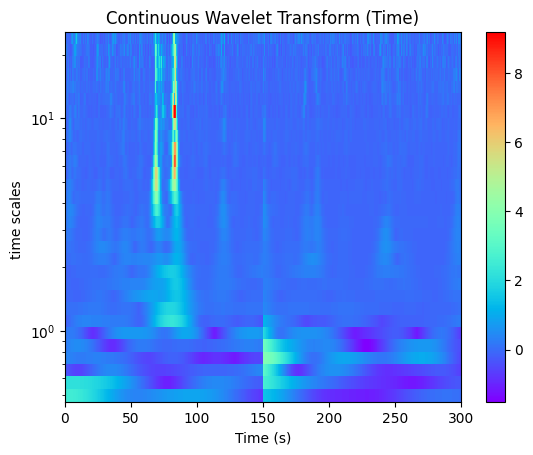

In [33]:

time_data = normed_data[127][:,:30]

time = np.linspace(0, 300, 600)
fig, axs = plt.subplots()


pcm = axs.pcolormesh(time, time_fourier[::-1], time_data.T, shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("time scales ")
axs.set_title("Continuous Wavelet Transform (Time)")
fig.colorbar(pcm, ax=axs)
fig.show()


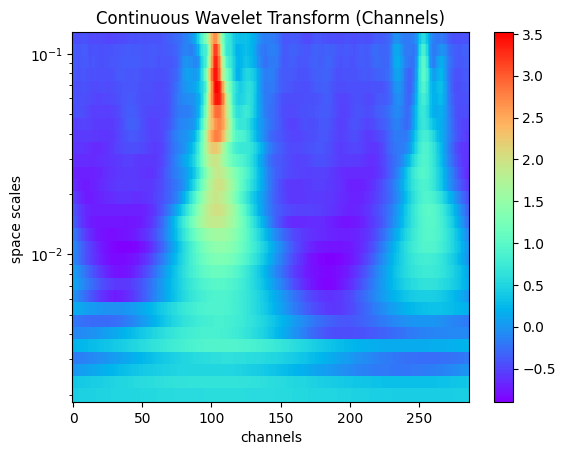

In [34]:
channels_data = normed_data[:,100,30:]

channels = np.linspace(0, 286, 286)
fig, axs = plt.subplots()
pcm = axs.pcolormesh(channels, space_fourier[::-1], channels_data.T,  shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("channels")
axs.set_ylabel("space scales ")
axs.set_title("Continuous Wavelet Transform (Channels)")
fig.colorbar(pcm, ax=axs)